# Model Representation Examples
## Produce the AskeNet Model Representation of "toy" SIR-based models by converting from template to MIRA to Aske representations.

In [1]:
import mira
from mira.metamodel import Concept, ControlledConversion, GroupedControlledConversion, Initial, NaturalConversion, Parameter, Template, TemplateModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel

from pyciemss import interfaces
from pyciemss.PetriNetODE import interfaces

import sympy

# Model 2: SEIARHD
## Define `Concepts` (model state variables)
Model 2 state variables: Susceptible (S), Exposed (E), Symptomatic Infectious (I), Asymptomatic Infectious (A), Recovered (R), Hospitalized (H), <br> and Deceased (D)

In [2]:
susceptible = Concept(name="susceptible_population", identifiers={"ido": "0000514"})
exposed = Concept(name="exposed_population", identifiers={"ido": "0000594"}) # http://purl.obolibrary.org/obo/IDO_0000594
symptomatic = Concept(name="symptomatic_population", identifiers={"ido": "0000573"}) # http://purl.obolibrary.org/obo/IDO_0000573
asymptomatic = Concept(name="asymptomatic_population", identifiers={"ido": "0000569"}) # http://purl.obolibrary.org/obo/IDO_0000569
recovered = Concept(name="recovered_population", identifiers={"ido": "0000592"})
hospitalized = Concept(name="hospitalized_population", identifiers={"ncit": "C25179"})
deceased = Concept(name="deceased_population", identifiers={"ncit": "C168970"}) # http://purl.obolibrary.org/obo/NCIT_C168970

# Set a value for the total population
total_pop = 100000

## Define conversion templates

In [3]:
state_variables = "beta, total_population, susceptible_population, delta, symptomatic_population, asymptomatic_population, pS, alpha, exposed_population, gamma, hosp, dnh, dh, los, hospitalized_population, recovered_population, deceased_population"
beta, N, S, delta, I, A, pS, alpha, E, gamma, hosp, dnh, dh, los, H, R, D = sympy.symbols(state_variables)
                                                                                                                                                                                                                            
S_to_E = GroupedControlledConversion(
    controllers = [
        symptomatic, 
        asymptomatic, 
    ],
    subject=susceptible,
    outcome=exposed,
    rate_law=(beta/N)*S*(delta*I + A)
)
E_to_I = NaturalConversion(
    subject=exposed,
    outcome=symptomatic,
    rate_law=(pS/alpha)*E
)
E_to_A = NaturalConversion(
    subject=exposed,
    outcome=asymptomatic,
    rate_law=((1-pS)/alpha)*E
)
I_to_R = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_H = NaturalConversion(
    subject=symptomatic,
    outcome=recovered,
    rate_law=gamma*(1-hosp-dnh)*I
)
I_to_D = NaturalConversion(
    subject=symptomatic,
    outcome=deceased,
    rate_law=gamma*dnh*I
)
A_to_R = NaturalConversion(
    subject=asymptomatic,
    outcome=recovered,
    rate_law=gamma*A
)
H_to_R = NaturalConversion(
    subject=hospitalized,
    outcome=recovered,
    rate_law=((1-dh)/los)*H
)
H_to_D = NaturalConversion(
    subject=hospitalized,
    outcome=deceased,
    rate_law=(dh/los)*H
)

# display(S_to_E.rate_law.args[0])

## Set up the template model, define parameter values and initial conditions

In [4]:
tm = TemplateModel(
    templates=[S_to_E, E_to_I, E_to_A, I_to_R, I_to_H, I_to_D, A_to_R, H_to_R, H_to_D],
    parameters={
        'beta': Parameter(name='beta', value=0.55), # transmission rate
        'total_population': Parameter(name='total_population', value=total_pop),
        'delta': Parameter(name='delta', value=1.5), # difference in infectiousness symptomatic/asymptomatic
        'pS': Parameter(name='pS', value=0.7), # percent of exposures which become symptomatic
        'alpha': Parameter(name='alpha', value=4), # latency period
        'gamma': Parameter(name='gamma', value=0.2), # recovery rate
        'hosp': Parameter(name='hosp', value=0.1), # hospitalization rate of infectious individuals
        'dnh': Parameter(name='dnh', value=0.001), # death rate of infectious individuals (never hospitalized)
        'dh': Parameter(name='dh', value=0.1), #  death rate of infectious individuals (hospitalized)
        'los': Parameter(name='los', value=7), # average length (days) of hospital stay
    },
    initials={
        'susceptible_population': (Initial(concept=susceptible, value=(total_pop - 1))), 
        'symptomatic_population': (Initial(concept=symptomatic, value=1)),
        'asymptomatic_population': (Initial(concept=asymptomatic, value=0)),
        'exposed_population': (Initial(concept=exposed, value=0)),
        'hospitalized_population': (Initial(concept=hospitalized, value=0)),
        'recovered_population': (Initial(concept=recovered, value=0)),
        'deceased_population': (Initial(concept=deceased, value=0)),
    }
)

display(type(tm)) # confirm that tm is a TemplateModel
# display(tm.dict())

mira.metamodel.template_model.TemplateModel

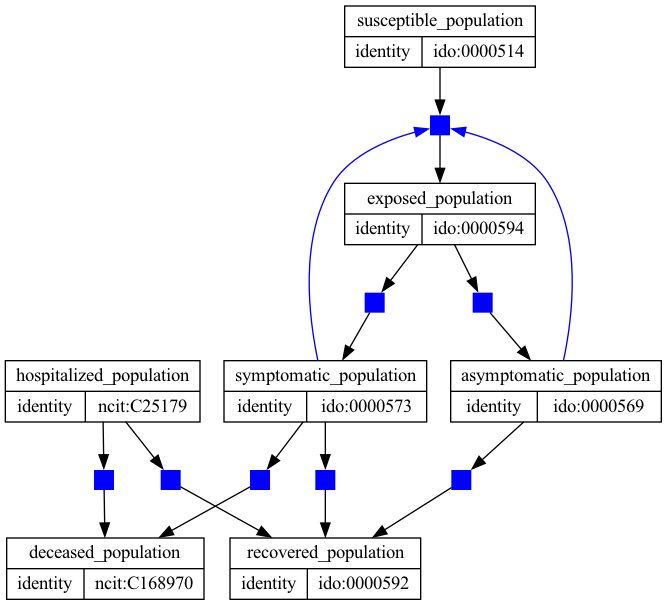

In [5]:
# Visualize the TemplateModel
GraphicalModel.for_jupyter(tm, width="20%")

## Convert to MIRA model representation 

In [6]:
mira_m = Model(tm)
display(type(mira_m)) 
#mira_m.variables

mira.modeling.Model

## Convert to AskeNet Model Representation (AMR) and output JSON file

In [7]:
aske_m = AskeNetPetriNetModel(mira_m)

# Display AMR model in JSON format
display(aske_m.to_json())

# Save AMR model as JSON file
aske_m.to_json_file("SEIARHD_AMR.json", indent=2)

{'name': 'Model',
 'schema': 'https://raw.githubusercontent.com/DARPA-ASKEM/Model-Representations/petrinet_v0.5/petrinet/petrinet_schema.json',
 'schema_name': 'petrinet',
 'description': 'Model',
 'model_version': '0.1',
 'properties': {},
 'model': {'states': [{'id': 'susceptible_population',
    'name': 'susceptible_population',
    'grounding': {'identifiers': {'ido': '0000514'}, 'modifiers': {}}},
   {'id': 'symptomatic_population',
    'name': 'symptomatic_population',
    'grounding': {'identifiers': {'ido': '0000573'}, 'modifiers': {}}},
   {'id': 'asymptomatic_population',
    'name': 'asymptomatic_population',
    'grounding': {'identifiers': {'ido': '0000569'}, 'modifiers': {}}},
   {'id': 'exposed_population',
    'name': 'exposed_population',
    'grounding': {'identifiers': {'ido': '0000594'}, 'modifiers': {}}},
   {'id': 'recovered_population',
    'name': 'recovered_population',
    'grounding': {'identifiers': {'ido': '0000592'}, 'modifiers': {}}},
   {'id': 'deceased_

In [8]:
# Import mira_m the pyciemss way
the_model = interfaces.load_petri_model(mira_m) 
the_model

ScaledBetaNoisePetriNetODESystem(
	total_population = Uniform(low: 90000.0, high: 110000.0),
	beta = Uniform(low: 0.4950000047683716, high: 0.6050000190734863),
	delta = Uniform(low: 1.350000023841858, high: 1.649999976158142),
	(('susceptible_population', ('identity', 'ido:0000514')), ('exposed_population', ('identity', 'ido:0000594')), (('symptomatic_population', ('identity', 'ido:0000573')), ('asymptomatic_population', ('identity', 'ido:0000569'))), 'GroupedControlledConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	pS = Uniform(low: 0.6299999952316284, high: 0.7699999809265137),
	alpha = Uniform(low: 3.5999999046325684, high: 4.400000095367432),
	(('exposed_population', ('identity', 'ido:0000594')), ('symptomatic_population', ('identity', 'ido:0000573')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, high: 1.0),
	(('exposed_population', ('identity', 'ido:0000594')), ('asymptomatic_population', ('identity', 'ido:0000569')), 'NaturalConversion', 'rate') = Uniform(low: 0.0, hig